# Identifying Invalid GPS Points in Taxi Trips

In [15]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import LineString, Point

In [16]:
def load_data(fname, skiprows, nrows):
    df = pd.read_csv(fname, skiprows=skiprows, nrows=nrows)
    df['traj'] = json.loads('[' + df.POLYLINE.str.cat(sep=',') + ']')
    df = df[df.traj.str.len() > 1].copy()
    df['lines'] = gpd.GeoSeries(df.traj.apply(LineString))
    return gpd.GeoDataFrame(df, geometry='lines')

#skiprows is updated for each run of the code, to walk through the whole dataset (range(1, 100000), range(1, 200000), ....)
df = load_data('train.csv', skiprows=range(1,1000000), nrows=100000)
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,traj,lines
0,1391373706620000651,B,NaN,15.0,20000651,1391373706,A,False,"[[-8.585658,41.148558],[-8.585685,41.148612],[...","[[-8.585658, 41.148558], [-8.585685, 41.148612...","LINESTRING (-8.58566 41.14856, -8.58568 41.148..."
1,1391429412620000163,C,NaN,NaN,20000163,1391429412,A,False,"[[-8.639523,41.164398],[-8.639532,41.164398],[...","[[-8.639523, 41.164398], [-8.639532, 41.164398...","LINESTRING (-8.63952 41.16440, -8.63953 41.164..."
2,1391427894620000356,C,NaN,NaN,20000356,1391427894,A,False,"[[-8.613144,41.173641],[-8.613117,41.173506],[...","[[-8.613144, 41.173641], [-8.613117, 41.173506...","LINESTRING (-8.61314 41.17364, -8.61312 41.173..."
3,1391426059620000359,A,6397.0,NaN,20000359,1391426059,A,False,"[[-8.620344,41.166414],[-8.620272,41.167008],[...","[[-8.620344, 41.166414], [-8.620272, 41.167008...","LINESTRING (-8.62034 41.16641, -8.62027 41.167..."
4,1391426096620000560,B,NaN,7.0,20000560,1391426096,A,False,"[[-8.639901,41.159808],[-8.64036,41.159862],[-...","[[-8.639901, 41.159808], [-8.64036, 41.159862]...","LINESTRING (-8.63990 41.15981, -8.64036 41.159..."


In [17]:
print(len(df))

96952


## The original sub-dataset, before cleaning:

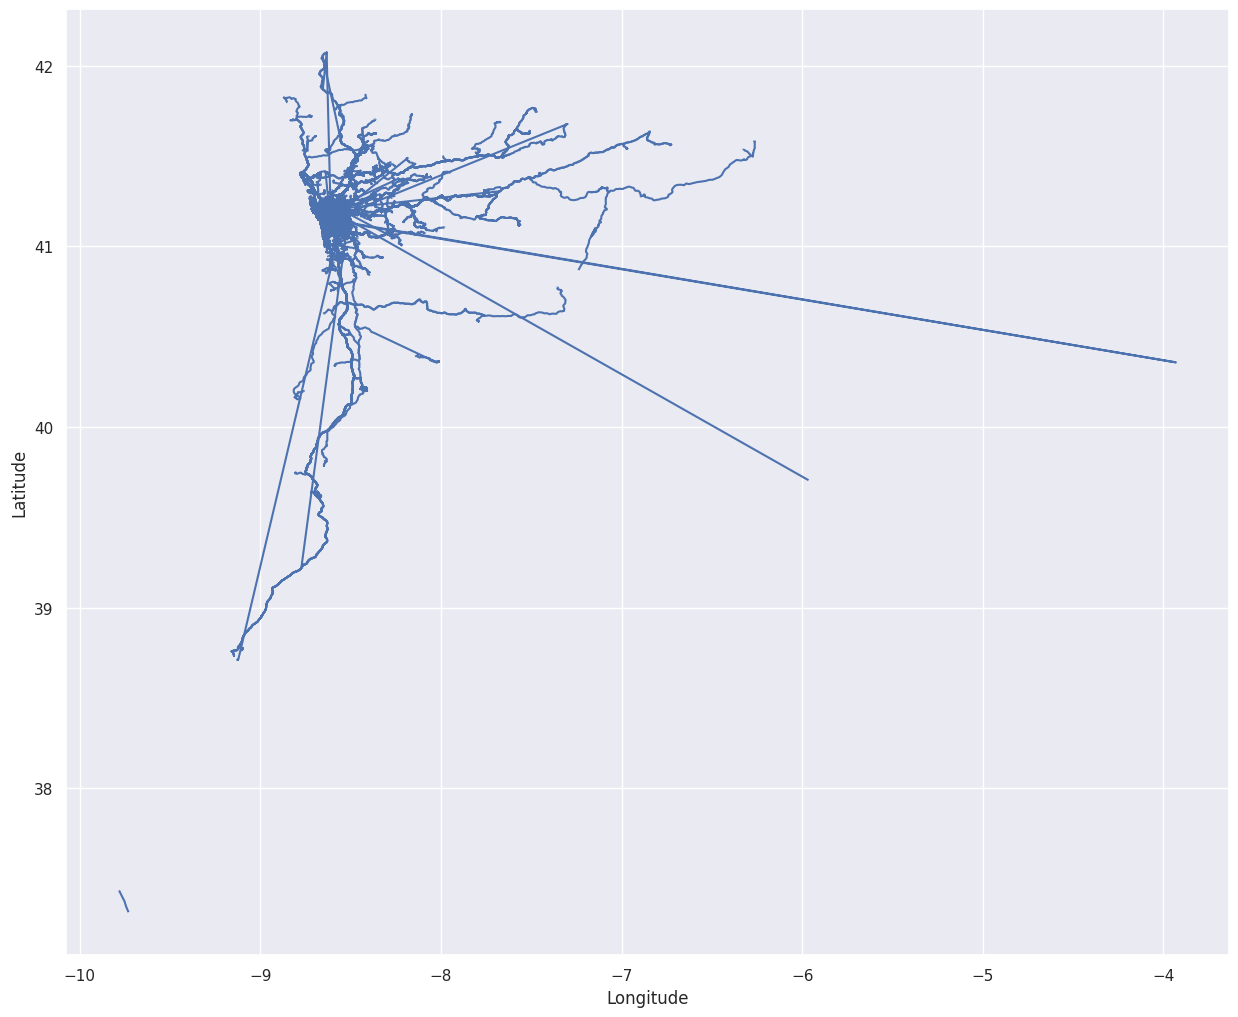

In [18]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15,8]
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

df.lines.plot(figsize=[15,15]);
plt.xlabel('Longitude')
plt.ylabel('Latitude');

In [19]:
from sklearn.metrics import DistanceMetric
metric = DistanceMetric.get_metric('haversine')
R = 6371 # radius of earth in km
dt = 15/3600 # coordinates are reported in 15 second intervals

In [20]:
def dist_sequence(coords):
    n = len(coords)
    dist = R*metric.pairwise(np.radians(coords)).ravel()
    offsets = (np.arange(n)[:,None] - np.arange(n)).ravel()
    return pd.DataFrame([offsets[offsets>0]*dt*60,dist[offsets>0]], index=['time_offset', 'distance']).T

dist_ungrouped = pd.concat(df.traj.apply(dist_sequence).values).set_index('time_offset')

In [21]:
dists = np.sqrt((dist_ungrouped**2).groupby('time_offset').mean()/2)

In [22]:
def fit_rational(x,y,w=1):
    ws = np.sqrt(w)
    (a,b),_,_,_ = np.linalg.lstsq(np.column_stack([x,-y])*ws[:,None], x*y*ws, rcond=None)
    return a*x/(x+b), (a,b)

dists['curve'], coeffs = fit_rational(dists.index.values, dists.distance.values, ((1+np.arange(len(dists)))/(1+len(dists)))**-3)

In [23]:
def likelihood(coords, ab):
    n = len(coords)
    a,b = coeffs
    dist = R*metric.pairwise(np.radians(coords))
    time = dt*60*np.abs(np.arange(n)[:,None] - np.arange(n))
    sigma = a*time/(time + b) + np.eye(n)
    lr = -0.5*(dist**2/sigma**2).sum(axis=1)
    return lr

def norm_lr(lr):
    return (lr-lr.max())/len(lr)

In [24]:
thresh = -2

In [25]:
bad_routes = df.traj.apply(lambda t: (norm_lr(likelihood(t,coeffs)) < thresh).any()).values
print("Routes with invalid points: {} / 100000".format(bad_routes.sum()))

Routes with invalid points: 567 / 100000


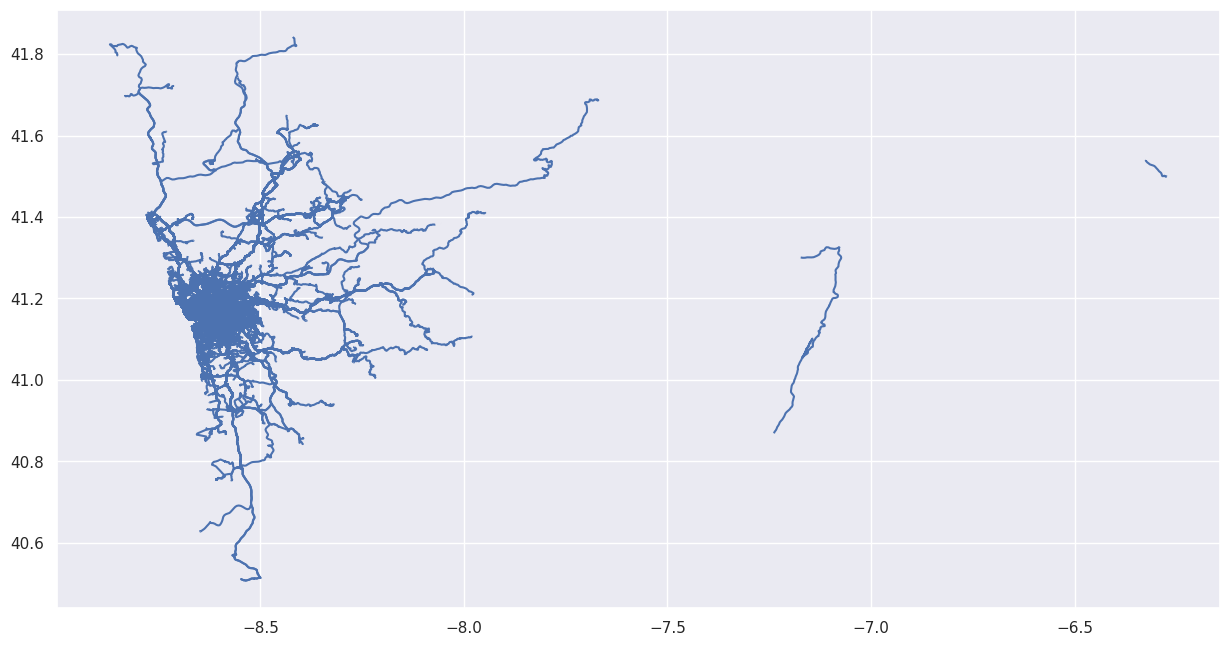

In [26]:
df[~bad_routes].lines.plot(figsize=[15,15]);

In [27]:
new_data = df[~bad_routes]
new_data.drop(['lines', 'traj'], axis=1, inplace=True)
new_data.to_csv('cleaned_data_1100001-1100000-NY.csv', index=False)

/tmp/ipykernel_1120915/1933075586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop(['lines', 'traj'], axis=1, inplace=True)


In [28]:
len(df[~bad_routes])

96385